# SALES RETURN ANALYSIS - RETURN PREDICTION MODELS

In [1]:
# Create Python SQL Connection

import pymysql 
from sqlalchemy import create_engine
import getpass 
password = getpass.getpass()

In [78]:
# Import libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn as skl
from sklearn import preprocessing


# Numeric variables
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Categoric variables
from sklearn.preprocessing import OneHotEncoder

# Data Balance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Train-Test
from sklearn.model_selection import train_test_split

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import statsmodels.api as sm

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree

# KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score


### 1. IMPORT DATA

In [3]:
# Create Python - MySQL connection 
connection_string = 'mysql+pymysql://root:' + password + '@localhost/superstore'
engine = create_engine(connection_string)

In [4]:
# Specify file path
filepath1 = "/Users/maravallejos/Ironhackk/SuperStore/superstore.xls"
# Create a copy in excel
xls = pd.ExcelFile(filepath1)

In [5]:
# Since the file has 3 sheets, get a list of sheet and loop through them before saving dataframe to MySql
sheet_names = xls.sheet_names
for sheet_name in sheet_names:
    df = pd.read_excel(xls, sheet_name=sheet_name)
    df.to_sql(name=sheet_name, con=engine, if_exists='replace', index=False)

In [172]:
# Retrieve MySQL query with joined tables as dataframe
query1 = '''SELECT sso.*, COALESCE(ssr.returned, 'No') AS returned, ssp.person
FROM ssorders sso
LEFT JOIN ssreturns ssr ON sso.order_id = ssr.order_id
LEFT JOIN sspeople ssp ON sso.region = ssp.region;'''

data = pd.read_sql_query(query1, connection_string) # engine se puede cambiar por la URL connection_string
data.head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,...,product_id,category,subcategory,product_name,sales,quantity,discount,profit,returned,person
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,262.0,2,0.00,41.9136,No,Cassandra Brandow
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",732.0,3,0.00,219.5820,No,Cassandra Brandow
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,15.0,2,0.00,6.8714,No,Anna Andreadi
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,958.0,5,0.45,-383.0310,No,Cassandra Brandow
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.0,2,0.20,2.5164,No,Cassandra Brandow


In [173]:
# Create copy of dataframe
data_copy = data.copy()

### 2. UNDERSTANDING THE DATASET

In [176]:
data.shape

(9994, 23)

In [177]:
data.dtypes

row_id                    int64
order_id                 object
order_date       datetime64[ns]
ship_date        datetime64[ns]
ship_mode                object
customer_id              object
customer_name            object
segment                  object
country                  object
city                     object
state                    object
postal_code               int64
region                   object
product_id               object
category                 object
subcategory              object
product_name             object
sales                   float64
quantity                  int64
discount                float64
profit                  float64
returned                 object
person                   object
dtype: object

In [178]:
data.isna().sum()

row_id           0
order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
customer_name    0
segment          0
country          0
city             0
state            0
postal_code      0
region           0
product_id       0
category         0
subcategory      0
product_name     0
sales            0
quantity         0
discount         0
profit           0
returned         0
person           0
dtype: int64

In [179]:
# Check unique values in object columns 
value_counts_dict = {}

for column in data.columns:
    if data[column].dtype == 'object':
        value_counts = data[column].value_counts()
        value_counts_dict[column] = value_counts

for column, counts in value_counts_dict.items():
    print(f'Variable: {column}')
    print(counts)
    print()

Variable: order_id
CA-2017-100111    14
CA-2017-157987    12
CA-2016-165330    11
US-2016-108504    11
CA-2015-131338    10
                  ..
CA-2016-157259     1
CA-2017-107986     1
US-2015-112508     1
US-2016-126844     1
CA-2017-119914     1
Name: order_id, Length: 5009, dtype: int64

Variable: ship_mode
Standard Class    5968
Second Class      1945
First Class       1538
Same Day           543
Name: ship_mode, dtype: int64

Variable: customer_id
WB-21850    37
JL-15835    34
MA-17560    34
PP-18955    34
CK-12205    32
            ..
LD-16855     1
AO-10810     1
CJ-11875     1
RE-19405     1
JR-15700     1
Name: customer_id, Length: 793, dtype: int64

Variable: customer_name
William Brown          37
John Lee               34
Matt Abelman           34
Paul Prost             34
Chloris Kastensmidt    32
                       ..
Lela Donovan            1
Anthony O'Donnell       1
Carl Jackson            1
Ricardo Emerson         1
Jocasta Rupert          1
Name: customer_name,

In [180]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
row_id,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
postal_code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
sales,9994.0,229.871823,623.248607,0.000,17.00000,54.0000,210.000,22638.000
quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


### 3. DATA PREPARATION

##### CREATE, MODIFY AND SELECT VARIABLES FOR MODELLING

In [181]:
# Create variable with days that have passed between order placement and order shipping.
data['days_to_ship'] = (data['ship_date'] - data['order_date']).dt.days

In [182]:
# Create variable with the month the order was placed (1 = January, 12 = December). 
data['order_month'] = data['order_date'].dt.strftime('%B')

In [183]:
# Create variable with the day of the week the order was placed (0 = Monday, 6 = Sunday). 
data['order_day_of_week'] = data['order_date'].dt.strftime('%A')

In [184]:
# Replace 'Yes' and 'No' values for 'returned' variable
data['returned'] = data['returned'].replace({'No': 0, 'Yes': 1})

In [185]:
# Save data dataframe to be used in Tableau analysis
filepath2 = "/Users/maravallejos/Ironhackk/Sales_Return_Analysis/superstore_tableau.xls"
# Create a copy in excel
data.to_excel(filepath2, index=False)

In [186]:
# Check subcategory values
data['subcategory'].unique()

array(['Bookcases', 'Chairs', 'Labels', 'Tables', 'Storage',
       'Furnishings', 'Art', 'Phones', 'Binders', 'Appliances', 'Paper',
       'Accessories', 'Envelopes', 'Fasteners', 'Supplies', 'Machines',
       'Copiers'], dtype=object)

In [187]:
# Encode variable 'subcategory'
data = pd.get_dummies(data, columns=['subcategory'], prefix='subcategory', drop_first = False)

In [188]:
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'product_name',
       'sales', 'quantity', 'discount', 'profit', 'returned', 'person',
       'days_to_ship', 'order_month', 'order_day_of_week',
       'subcategory_Accessories', 'subcategory_Appliances', 'subcategory_Art',
       'subcategory_Binders', 'subcategory_Bookcases', 'subcategory_Chairs',
       'subcategory_Copiers', 'subcategory_Envelopes', 'subcategory_Fasteners',
       'subcategory_Furnishings', 'subcategory_Labels', 'subcategory_Machines',
       'subcategory_Paper', 'subcategory_Phones', 'subcategory_Storage',
       'subcategory_Supplies', 'subcategory_Tables'],
      dtype='object')

Variable 'accesories' is reference category

In [189]:
# Modify all column names to lower string
data = data.rename(columns=str.lower)

In [190]:
# Create dataframe excluding unnecessary variables except order_id (dataframe is going to be agregated by order_id)
data_model = data.drop(['row_id', 'order_date', 'ship_date', 'customer_id', 'customer_name', 'country', 'state', 'city','postal_code', 'category', 'product_id','product_name', 'person'], axis = 1)

In [191]:
# Group data by order_id:

# Define the aggregation for each column. 
# For variables related to subcategories and discount, an addition is going to be performed to identify if the order has (or not) these features and 
# not loose information when aggregated. 
agg_funcs = {
    'sales': 'sum',
    'quantity': 'sum',
    'discount': 'sum', 
    'profit': 'sum',
    'subcategory_accessories': 'sum', 
    'subcategory_appliances': 'sum', 
    'subcategory_art': 'sum', 
    'subcategory_binders': 'sum',
    'subcategory_bookcases': 'sum', 
    'subcategory_chairs': 'sum', 
    'subcategory_copiers': 'sum',
    'subcategory_envelopes': 'sum', 
    'subcategory_fasteners': 'sum',
    'subcategory_furnishings': 'sum', 
    'subcategory_labels': 'sum', 
    'subcategory_machines': 'sum',
    'subcategory_paper': 'sum', 
    'subcategory_phones': 'sum', 
    'subcategory_storage': 'sum',
    'subcategory_supplies': 'sum', 
    'subcategory_tables': 'sum'
}

# Group by the selected columns (these variables remain the same throughout the order)
data_model = data_model.groupby([
    'order_id', 'ship_mode', 'segment', 'region', 'returned',
    'days_to_ship', 'order_month', 'order_day_of_week'
]).agg(agg_funcs).reset_index()


In [192]:
# Convert all variables related to subcategory to either 0 (order doesn't have product with category) or 1 (order has product with category)
cols_to_convert = ['subcategory_bookcases', 'subcategory_chairs', 'subcategory_labels', 'subcategory_tables', 'subcategory_storage', 
                    'subcategory_furnishings', 'subcategory_art', 'subcategory_phones', 'subcategory_binders', 'subcategory_appliances', 
                    'subcategory_paper', 'subcategory_accessories', 'subcategory_envelopes', 'subcategory_fasteners', 'subcategory_supplies', 
                    'subcategory_machines', 'subcategory_copiers']

data_model[cols_to_convert] = data_model[cols_to_convert].applymap(lambda x: 1 if x!=0 else '0')

# Convert all subcategory variables to object
data_model[cols_to_convert] = data[cols_to_convert].astype('object')

In [193]:
# Create binary variable to check if a product has a discount or not.
data_model['hasdiscount'] = data_model['discount'].apply(lambda x: '1' if x!=0 else '0')

# Since data has already been aggregated, drop variables 'discount' and 'order_id'
data_model.drop(['discount', 'order_id'], axis = 1, inplace = True)

### 4. DATA PREPROCESSING

CREATE CATEGORIC AND NUMERIC DATAFRAMES

In [194]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ship_mode                5009 non-null   object 
 1   segment                  5009 non-null   object 
 2   region                   5009 non-null   object 
 3   returned                 5009 non-null   int64  
 4   days_to_ship             5009 non-null   int64  
 5   order_month              5009 non-null   object 
 6   order_day_of_week        5009 non-null   object 
 7   sales                    5009 non-null   float64
 8   quantity                 5009 non-null   int64  
 9   profit                   5009 non-null   float64
 10  subcategory_accessories  5009 non-null   object 
 11  subcategory_appliances   5009 non-null   object 
 12  subcategory_art          5009 non-null   object 
 13  subcategory_binders      5009 non-null   object 
 14  subcategory_bookcases   

In [195]:
# Create categoric dataframe
data_model_cat = data_model.select_dtypes(object)

In [196]:
# Create numeric dataframe
data_model_num = data_model.select_dtypes(np.number)

# Drop variable 'returned' from numeric dataframe and create target variables 'y'.
data_model_num.drop(['returned'], axis = 1, inplace = True)
y = data_model[['returned']]

#### 4.1 ANALYZE NUMERIC VARIABLES

In [197]:
data_model_num.describe().T

,count,mean,std,min,25%,50%,75%,max
days_to_ship,5009.0,3.957477,1.736998,0.0000,3.0000,4.0000,5.0000,7.0000
sales,5009.0,458.642244,954.743656,1.0000,38.0000,152.0000,512.0000,23660.0000
quantity,5009.0,7.560990,6.220034,1.0000,3.0000,6.0000,10.0000,52.0000
profit,5009.0,57.176487,344.937752,-6892.3748,2.0525,16.2758,68.6868,8762.3891


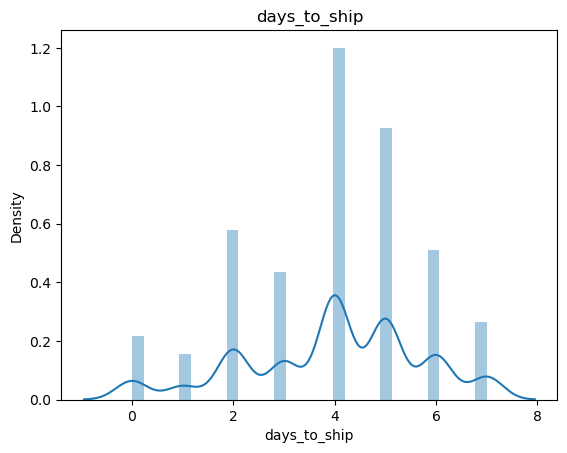

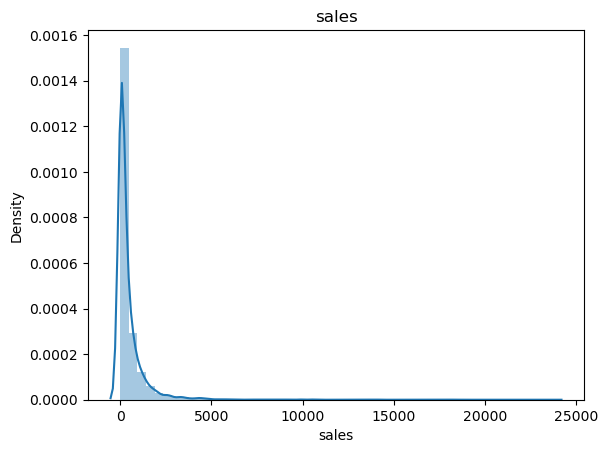

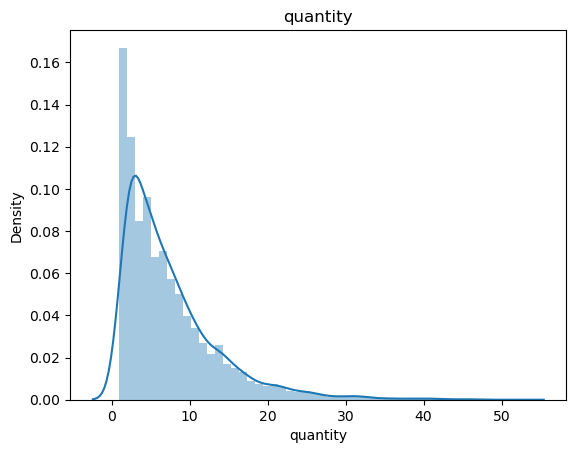

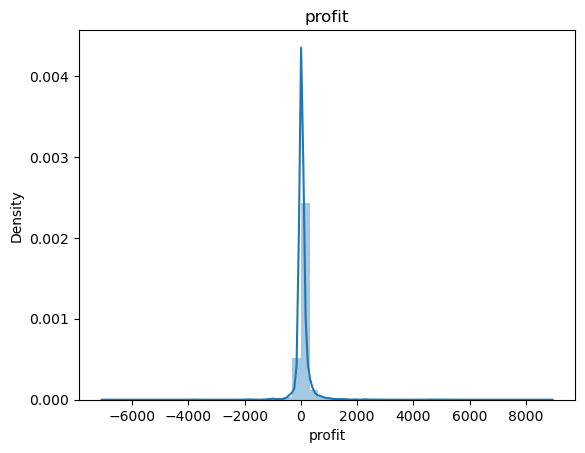

In [198]:
# Graph distributions for numeric columns.
for col in data_model_num.columns:
    sns.distplot(data_model_num[col])
    plt.title(col)
    plt.show()

All numeric variables except 'days_to_ship' have outliers. Since it is a first approach to understanding data, all observations will be taken into account.

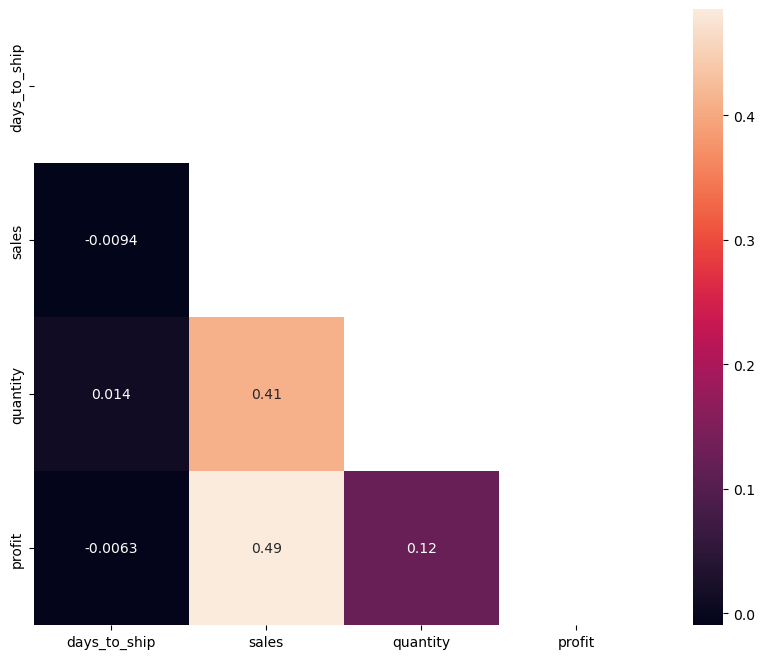

In [199]:
# Check for correlation in numeric variables.
data_corr = data_model_num.corr()
mask = np.zeros_like(data_corr) 
mask[np.triu_indices_from(mask)] = True 
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(data_corr, mask=mask, annot=True) 
plt.show()

There is no correlation present among numeric variables.

In [200]:
# Calculate Variance Inflaction Factor to check for multicollineality
vif = {}
numeric_col_vif = add_constant(data_model_num)
for i in np.arange(numeric_col_vif.shape[1]):
    column_name = numeric_col_vif.columns[i]
    value = variance_inflation_factor(np.array(numeric_col_vif), i)
    vif[column_name] = value

vif

{'const': 7.596665309589017,
 'days_to_ship': 1.0004580071821518,
 'sales': 1.5635405839273089,
 'quantity': 1.2143352904936437,
 'profit': 1.3196500775771405}

There is no multicollinearity among numeric variables.

##### 4.1.1 TRANSFORM NUMERIC VARIABLES TO COMPENSATE FOR DIFFERENT MAGNITUDES

In [201]:
# Use Standard Scaler to transform numeric variables.
scaler = MinMaxScaler()
data_model_num_scaled = scaler.fit_transform(data_model_num)
data_model_num_scaled = pd.DataFrame(data_model_num_scaled, columns=data_model_num.columns)

#### 4.2 ANALYZE CATEGORIC VARIABLES

In [202]:
for column in data_model_cat.columns:
    unique_categories = data_model_cat[column].unique()
    print(f"Variable: {column}")
    print(f"Categories: {unique_categories}")
    print()

Variable: ship_mode
Categories: ['Standard Class' 'Second Class' 'First Class' 'Same Day']

Variable: segment
Categories: ['Consumer' 'Corporate' 'Home Office']

Variable: region
Categories: ['East' 'West' 'South' 'Central']

Variable: order_month
Categories: ['September' 'July' 'March' 'January' 'April' 'May' 'December' 'November'
 'October' 'June' 'August' 'February']

Variable: order_day_of_week
Categories: ['Sunday' 'Tuesday' 'Friday' 'Monday' 'Wednesday' 'Saturday' 'Thursday']

Variable: subcategory_accessories
Categories: [0 1]

Variable: subcategory_appliances
Categories: [0 1]

Variable: subcategory_art
Categories: [0 1]

Variable: subcategory_binders
Categories: [0 1]

Variable: subcategory_bookcases
Categories: [1 0]

Variable: subcategory_chairs
Categories: [0 1]

Variable: subcategory_copiers
Categories: [0 1]

Variable: subcategory_envelopes
Categories: [0 1]

Variable: subcategory_fasteners
Categories: [0 1]

Variable: subcategory_furnishings
Categories: [0 1]

Variable: 

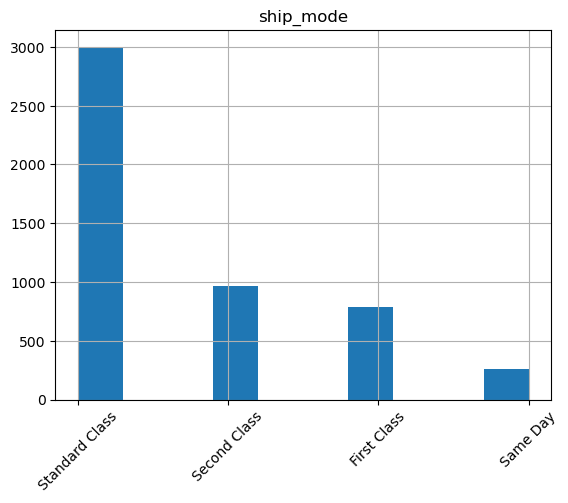

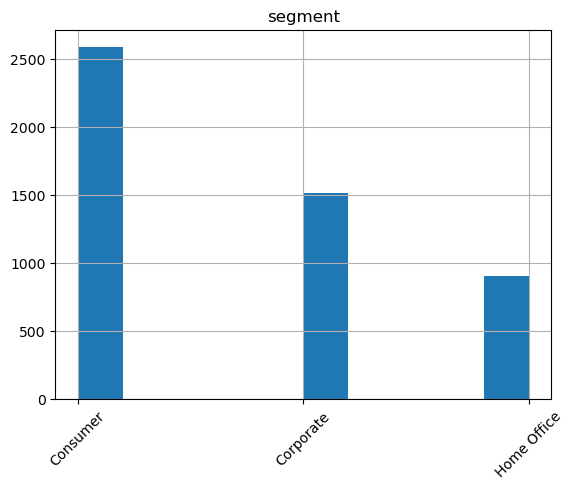

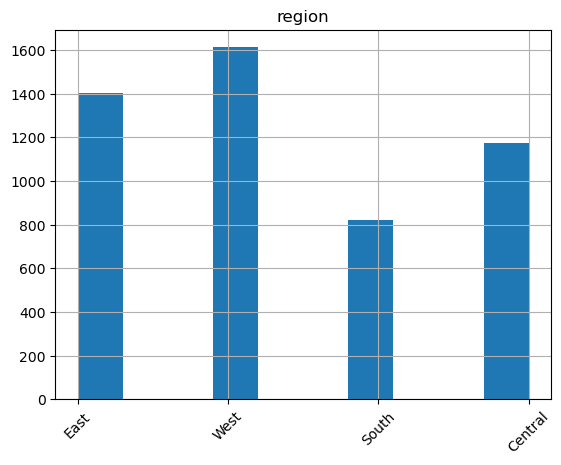

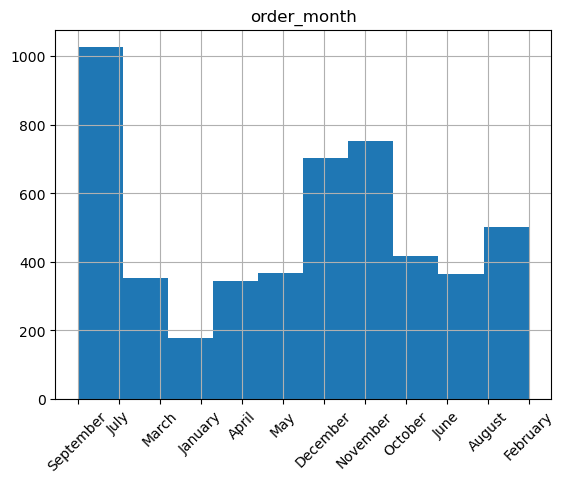

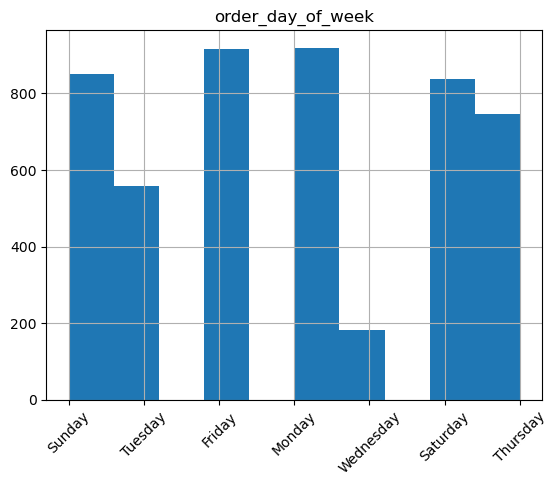

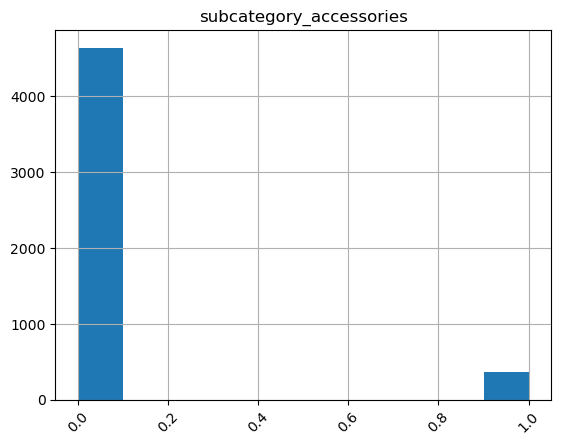

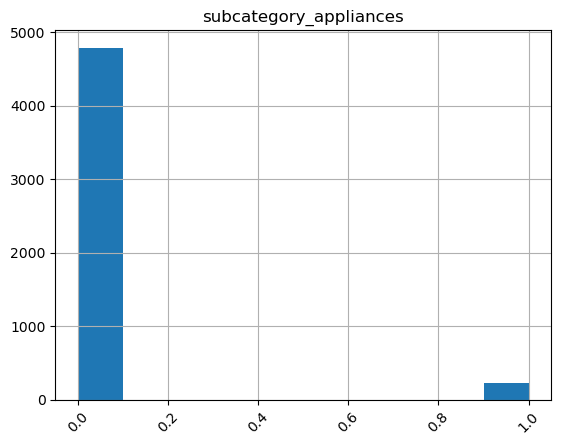

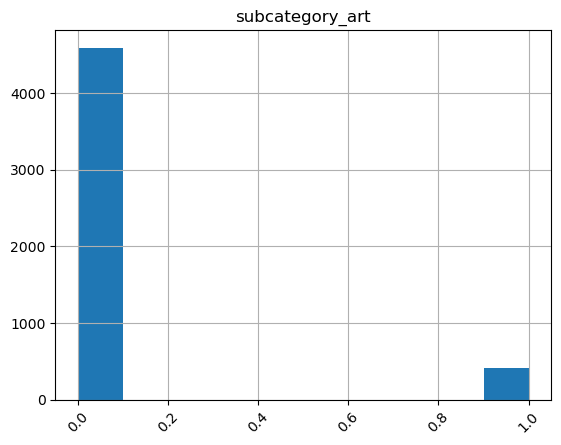

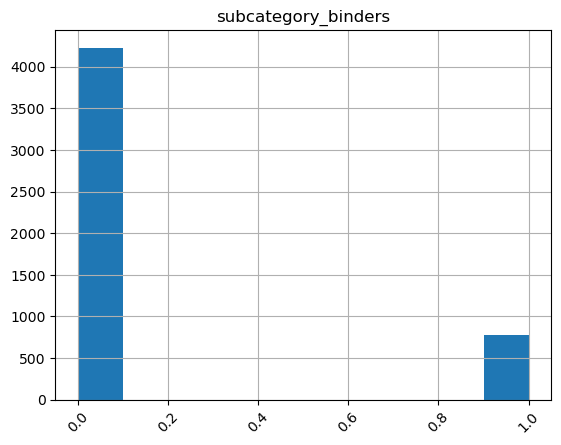

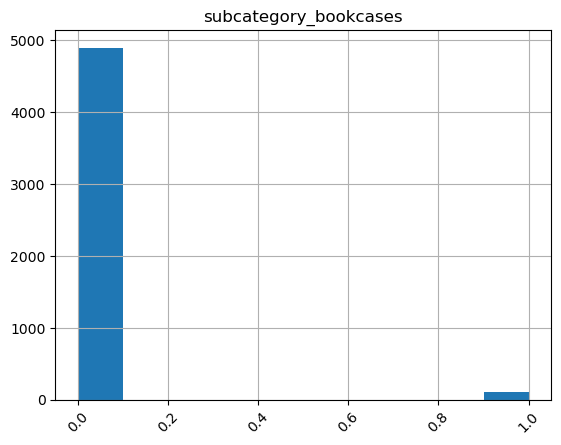

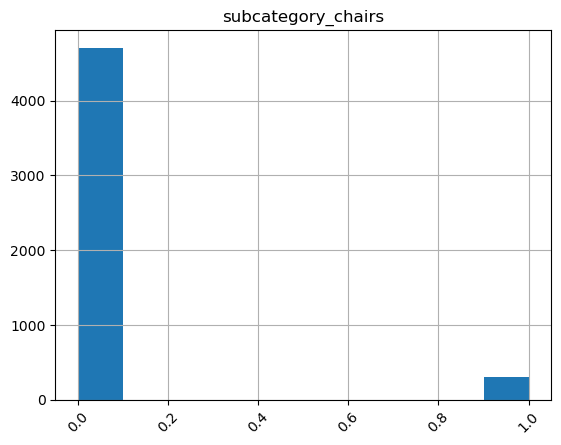

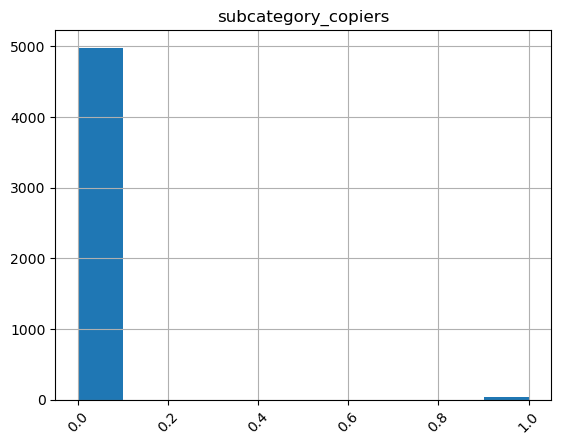

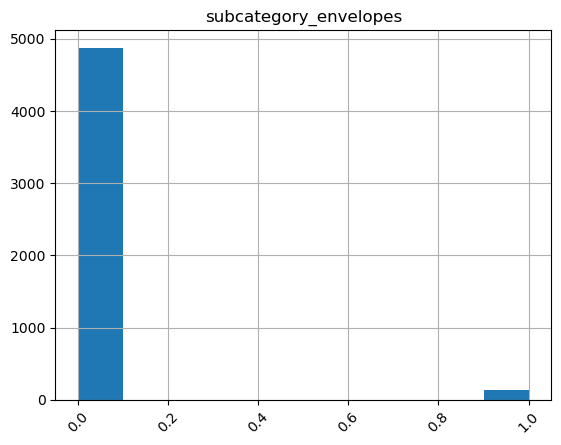

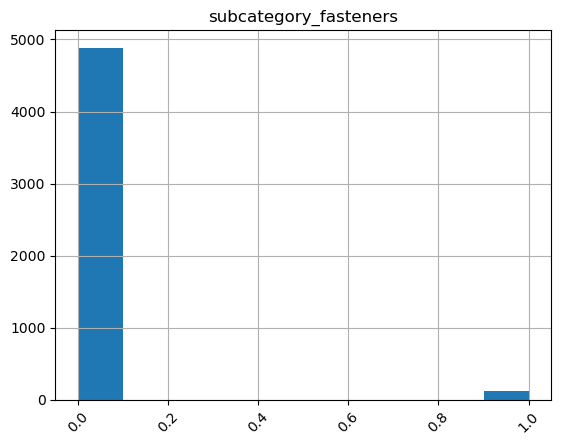

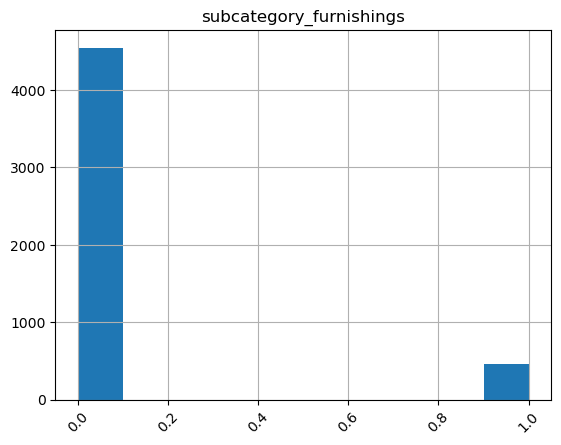

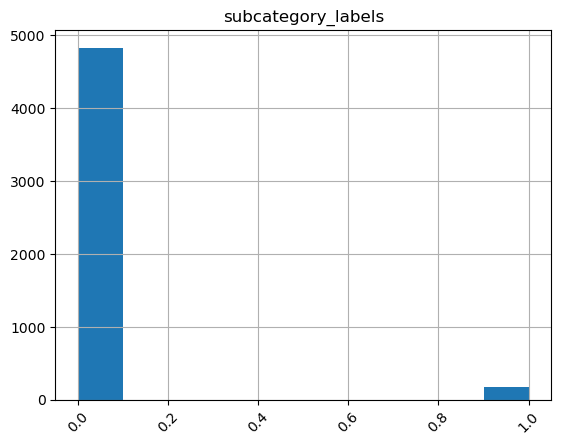

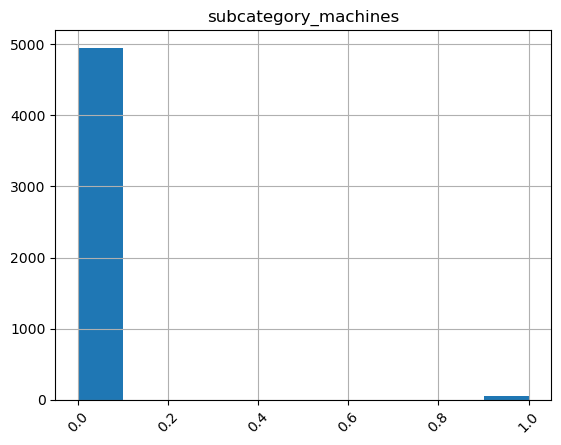

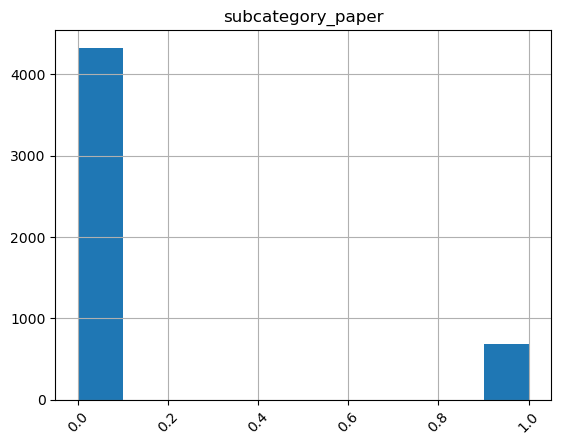

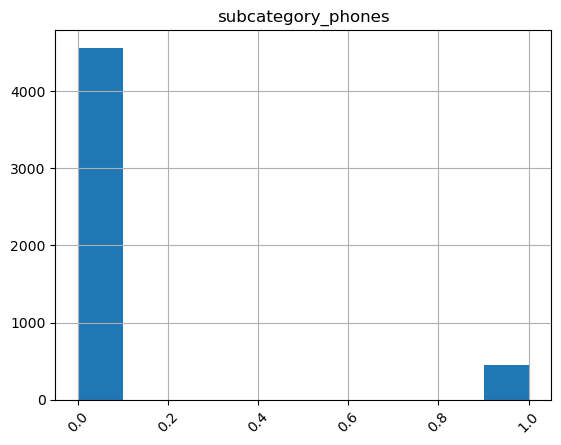

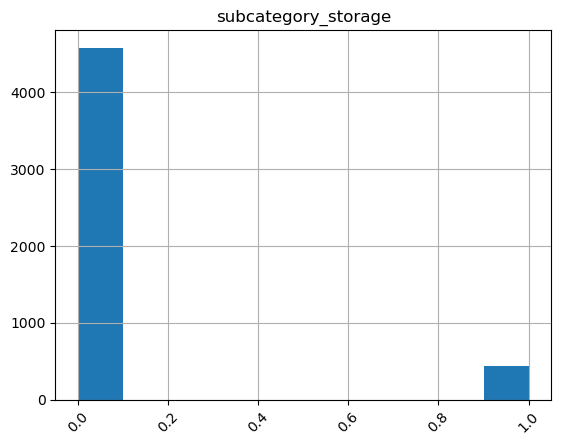

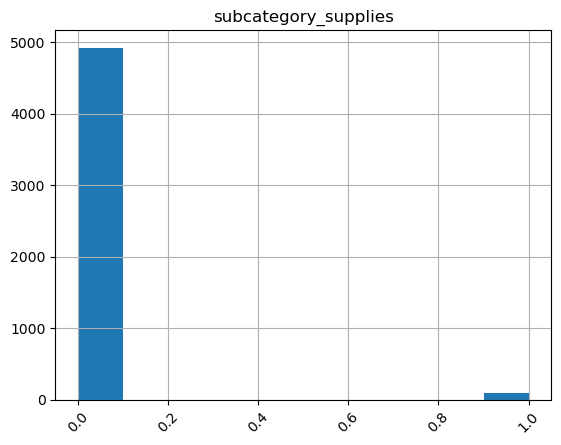

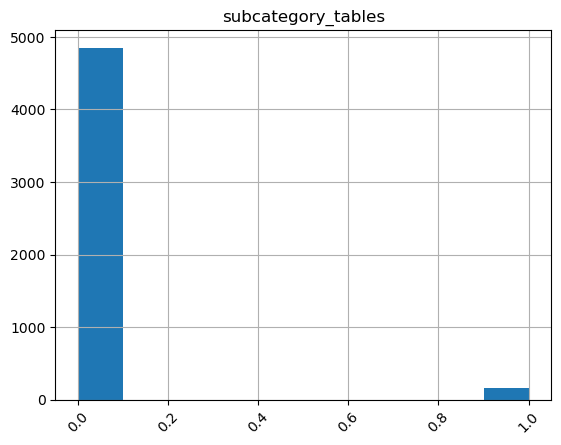

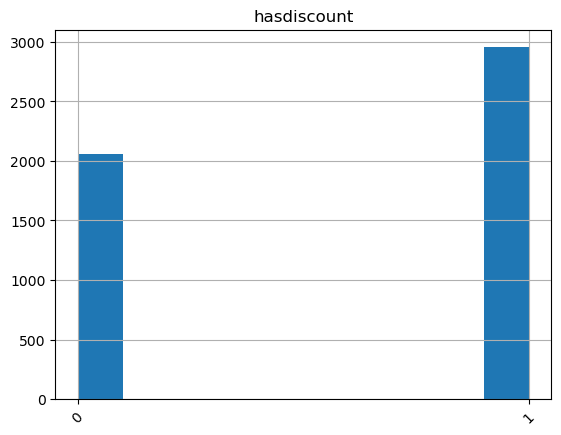

In [203]:
def hist_distribution(data_model_cat, rotation=45):
    for col in data_model_cat.columns:
        data_model_cat[col].hist(bins=10)
        plt.title(col)
        plt.xticks(rotation=rotation)  # Rotate x-axis labels
        plt.show()

# Call the function with a rotation angle, e.g., 45 degrees
hist_distribution(data_model_cat)

##### 4.2.1 ENCODE CATEGORIC VARIABLES TO CREATE DUMMY VARIABLES 

In [204]:
# Use OneHotEncoder to create dummy variables.
encoder = OneHotEncoder(sparse=False, drop='first')

# Columns to encode:
categorical_cols = data_model_cat.columns

# Fit and transform the categorical columns
encoded_data = encoder.fit_transform(data_model_cat[categorical_cols])

# Get variables' names and create dataframe with encoded variables.
encoded_feature_names = encoder.get_feature_names_out(input_features=categorical_cols)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

# Concatenate the encoded dataframe with the original DataFrame
data_model_cat_encoded = pd.concat([data_model_cat, encoded_df], axis=1)

# Drop the original categorical columns so there is no redundant information for the model.
data_model_cat_encoded = data_model_cat_encoded.drop(categorical_cols, axis=1)

#### 4.3 CONCATENATE TRANSFORMED DATAFRAMES

In [205]:
X = pd.concat([data_model_num_scaled, data_model_cat_encoded], axis = 1)

In [206]:
X.shape

(5009, 47)

In [207]:
y.shape

(5009, 1)

#### 4.4 DATA BALANCE

In [208]:
# Check target variable for data balance.
y.value_counts()

returned
0           4713
1            296
dtype: int64

Target variable refers to returned orders, which represent less than 10% of the data observations. It is going to be necessary to balance the data so the predictive models can perform. 

In [209]:
# Upsample data using SMOTE

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

returned
0           4713
1           4713
dtype: int64

In [210]:
# Train test
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size=.2, random_state=0)

SMOTE allowed for data balance, so undersampling using TomeLinks is not necessary. 

## 5. MODELLING

### 5.1 LOGISTIC REGRESSION

In [237]:
# Define model function

def logistic_regression(X_train, X_test, y_train, y_test):
    
    # Define model
    classification_lr = LogisticRegression(solver='lbfgs')

    # Fit model
    classification_lr.fit(X_train, y_train)

    # Predictions
    y_pred_lr = classification_lr.predict(X_test)
    
    # Indicators
    accuracy_lr = accuracy_score(y_test, y_pred_lr)
    precision_lr = precision_score(y_test, y_pred_lr)
    recall_lr = recall_score(y_test, y_pred_lr)
    f1_score_lr = f1_score(y_test, y_pred_lr)
    confusion_matrix_lr = confusion_matrix(y_test, y_pred_lr)
    cv_scores_lr = cross_val_score(classification_lr, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score_lr = np.mean(cv_scores_lr)
    tn, fp, fn, tp = confusion_matrix_lr.ravel()
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)
    

    # Coefficients
    coefficients = classification_lr.coef_[0]
    features = X_train.columns
    coefficients_lr_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    sorted_coef_lr = coefficients_lr_df.reindex(coefficients_lr_df['Coefficient'].abs().sort_values(ascending=False).index)

    # Return indicators
    results = {
        'Model': classification_lr,
        'Accuracy': accuracy_lr,
        'Precision': precision_lr,
        'Recall': recall_lr,
        'Specificity': specificity,
        'Negative Predictive Value': npv,
        'F1_score': f1_score_lr,
        'Mean Cross-Validation': mean_cv_score_lr,
        'Confusion matrix': confusion_matrix_lr,
        'Coefficients': sorted_coef_lr
    }

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_lr, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return results


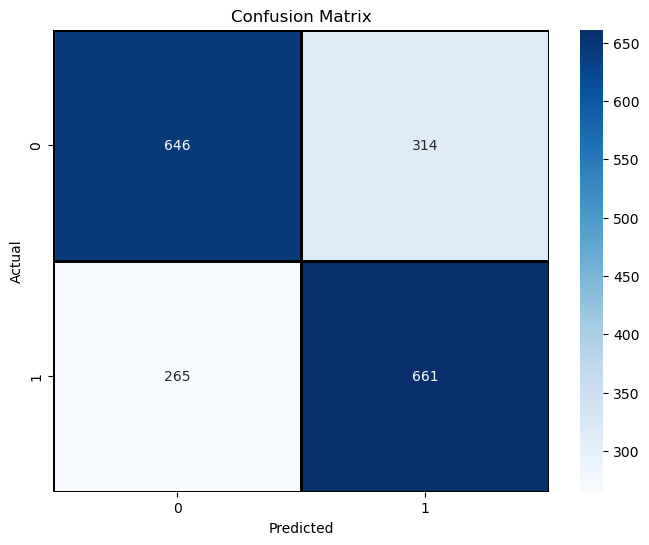

{'Model': LogisticRegression(),
 'Accuracy': 0.693001060445387,
 'Precision': 0.6779487179487179,
 'Recall': 0.7138228941684666,
 'Specificity': 0.6729166666666667,
 'Negative Predictive Value': 0.7091108671789242,
 'F1_score': 0.695423461336139,
 'Mean Cross-Validation': 0.696949602122016,
 'Confusion matrix': array([[646, 314],
        [265, 661]]),
 'Coefficients':                         Feature  Coefficient
 2                      quantity     3.752706
 11                  region_West     1.536902
 45         subcategory_tables_1    -0.999589
 17             order_month_June    -0.948131
 40       subcategory_machines_1     0.893036
 44       subcategory_supplies_1     0.875227
 1                         sales    -0.741949
 28  order_day_of_week_Wednesday    -0.663378
 19              order_month_May    -0.548689
 22        order_month_September    -0.530945
 33      subcategory_bookcases_1    -0.514486
 12           order_month_August    -0.490369
 27    order_day_of_week_Tuesday

In [238]:
# Call function with balanced data
model_lr = logistic_regression(X_train_sm, X_test_sm, y_train_sm, y_test_sm)
model_lr

### 5.2 RANDOM FOREST CLASSIFIER

In [241]:
# Define model function

def random_forest_classifier(X_train, X_test, y_train, y_test):
    
    # Define model
    classification_rf = RandomForestClassifier()

    # Define the parameter grid for grid search
    param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 75],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2', 'None']
}

    # Grid Search (param_grid will be defined asfterwards to be able to modify it as needed)
    grid_search = GridSearchCV(classification_rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Define model's parameters through Search Grid
    best_rf_classifier = grid_search.best_estimator_

    # Predictions
    y_pred_rf = best_rf_classifier.predict(X_test)

    # Indicators
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf = precision_score(y_test, y_pred_rf)
    recall_rf = recall_score(y_test, y_pred_rf)
    f1_score_rf = f1_score(y_test, y_pred_rf)
    confusion_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    cv_scores_rf = cross_val_score(best_rf_classifier, X_train, y_train, cv=5)
    mean_cv_score_rf = np.mean(cv_scores_rf)
    tn, fp, fn, tp = confusion_matrix_rf.ravel()
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)

    # Dataframe to graph tree
    
    
    # Model's feature importances
    feature_importances = best_rf_classifier.feature_importances_
    importance = pd.DataFrame(list(zip(X.columns, feature_importances)))
    importance.columns = ['columns_name', 'score_feature_importance']
    sorted_importance = importance.sort_values (by='score_feature_importance', ascending=False)
    
    # Return the results as a dictionary
    results = {
        'Model': best_rf_classifier,
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'Specificity': specificity,
        'Negative Predictive Value': npv,
        'F1_score': f1_score_rf,
        'Mean Cross-Validation': mean_cv_score_rf,
        'Confusion matrix': confusion_matrix_rf,
        'Grid search estimators': best_rf_classifier,
        'Feature importance': sorted_importance,
        'X_train_rf' : X_train
    }

    # Graph confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return results

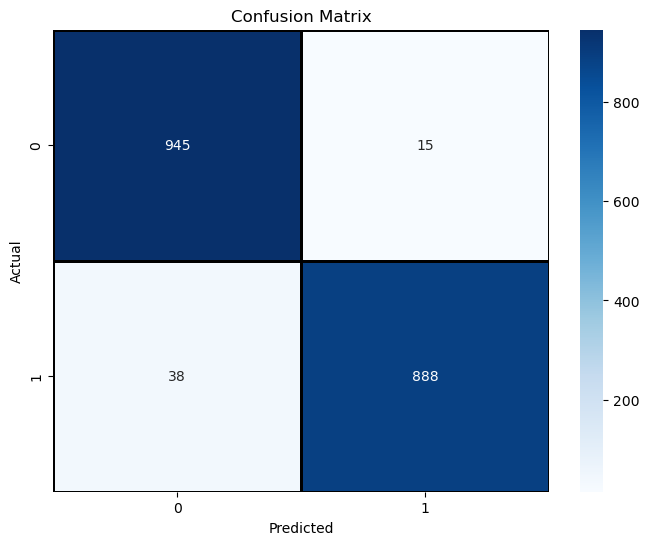

{'Model': RandomForestClassifier(max_features='log2', n_estimators=75),
 'Accuracy': 0.971898197242842,
 'Precision': 0.9833887043189369,
 'Recall': 0.958963282937365,
 'Specificity': 0.984375,
 'Negative Predictive Value': 0.9613428280773143,
 'F1_score': 0.9710224166211044,
 'Mean Cross-Validation': 0.9660477453580902,
 'Confusion matrix': array([[945,  15],
        [ 38, 888]]),
 'Grid search estimators': RandomForestClassifier(max_features='log2', n_estimators=75),
 'Feature importance':                    columns_name  score_feature_importance
 11                  region_West                  0.114193
 2                      quantity                  0.106378
 1                         sales                  0.078072
 0                  days_to_ship                  0.057128
 3                        profit                  0.057117
 46                hasdiscount_1                  0.052658
 9                   region_East                  0.041821
 7             segment_Corporate

In [242]:
# Call the function and store the results
model_rf = random_forest_classifier(X_train_sm, X_test_sm, y_train_sm, y_test_sm)
model_rf

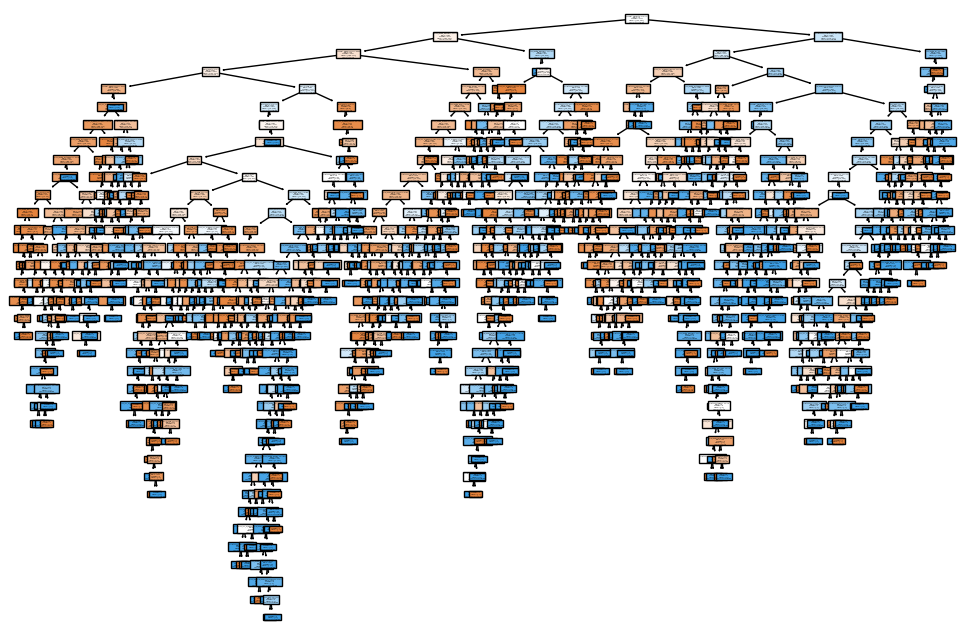

In [215]:
# Graph Random Forest
X_train_rf_plottree = model_rf['X_train_rf']

# Plot results
tree_to_plot = model_rf['Model'].estimators_[0]

# Define class names
class_names = ["Returned", "Not Returned"]

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(tree_to_plot, filled=True, feature_names=X_train_rf_plottree.columns, class_names=class_names)
plt.show()


In [268]:
# OPTIONAL: save features as excel file to be analyzed in Tableau
model_rf_features = model_rf['Feature importance']
filepath_model_rf_features = "/Users/maravallejos/Ironhackk/Sales_Return_Analysis/model_rf_features.xls"
model_rf_features.to_excel(filepath_model_rf_features, index=False)


In [269]:
model_rf_features

,columns_name,score_feature_importance
11,region_West,0.114193
2,quantity,0.106378
1,sales,0.078072
0,days_to_ship,0.057128
3,profit,0.057117
46,hasdiscount_1,0.052658
9,region_East,0.041821
7,segment_Corporate,0.028766
8,segment_Home Office,0.026170
10,region_South,0.024070


### 5.3 KNN MODEL

In [216]:
# Check for number of neighbours
score_knn = []
for i in range(2,10):
    model_knn = KNeighborsClassifier(n_neighbors=i)
    model_knn.fit(X, y)
    score_knn.append(model_knn.score(X, y))

Text(0, 0.5, 'Accuracy')

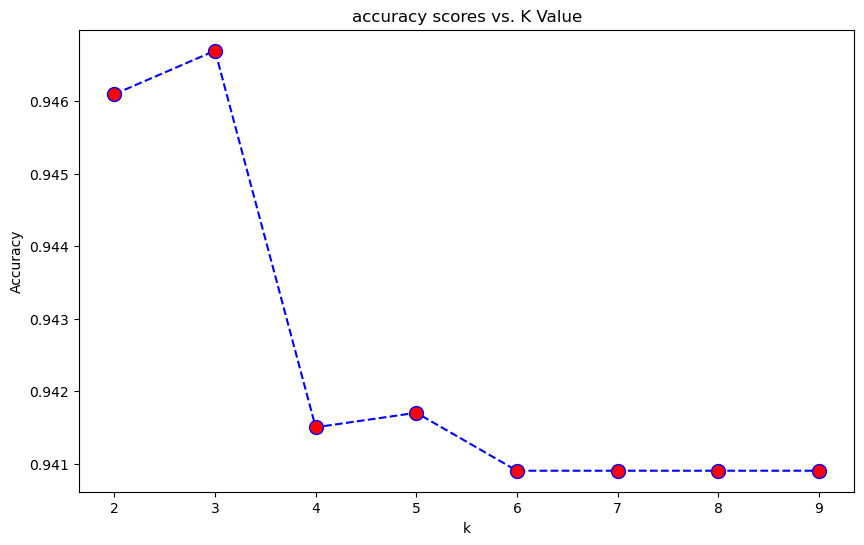

In [217]:
plt.figure(figsize=(10,6))
plt.plot(range(2,10),score_knn, color = 'blue', linestyle='dashed',
         marker='o', markerfacecolor='red', markersize=10)
plt.title('accuracy scores vs. K Value')
plt.xlabel('k')
plt.ylabel('Accuracy')

In [218]:
# Define number of neighbors to fit in model
K = 3

In [239]:
def knn_classifier(X_train, X_test, y_train, y_test, n_neighbors=K):
    
    # Define and fit the KNN classifier
    classification_knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    classification_knn.fit(X_train, y_train)

    # Predictions
    y_pred_knn = classification_knn.predict(X_test)

    # Indicators
    accuracy_knn = accuracy_score(y_test, y_pred_knn)
    precision_knn = precision_score(y_test, y_pred_knn)
    recall_knn = recall_score(y_test, y_pred_knn)
    f1_score_knn = f1_score(y_test, y_pred_knn)
    confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
    cv_scores_knn = cross_val_score(classification_knn, X_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score_knn = np.mean(cv_scores_knn)
    tn, fp, fn, tp = confusion_matrix_knn.ravel()
    specificity = tn / (tn + fp)
    npv = tn / (tn + fn)
    
    # Graph confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_knn, annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    results = {
        'Model': classification_knn,
        'Accuracy': accuracy_knn,
        'Precision': precision_knn,
        'Recall': recall_knn,
        'Specificity': specificity,
        'Negative Predictive Value': npv,
        'F1_score': f1_score_knn,
        'Mean Cross-Validation': mean_cv_score_knn,
        'Confusion matrix': confusion_matrix_knn
    }

    return results


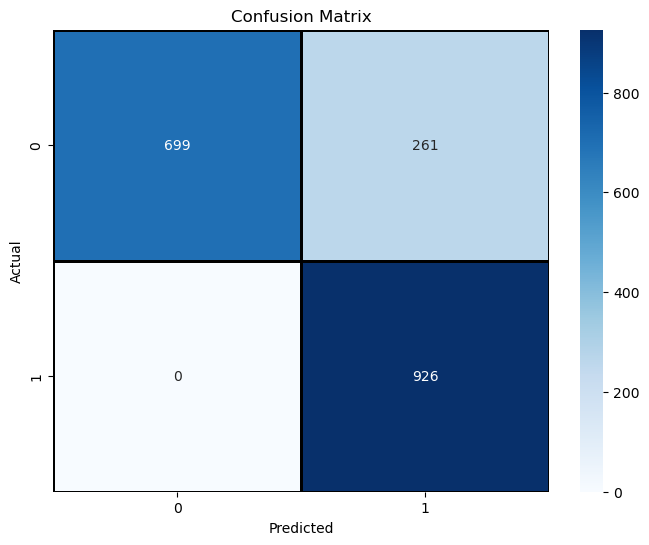

{'Model': KNeighborsClassifier(n_neighbors=3),
 'Accuracy': 0.8616118769883351,
 'Precision': 0.7801179443976411,
 'Recall': 1.0,
 'Specificity': 0.728125,
 'Negative Predictive Value': 1.0,
 'F1_score': 0.8764789398958827,
 'Mean Cross-Validation': 0.8484084880636604,
 'Confusion matrix': array([[699, 261],
        [  0, 926]])}

In [240]:
model_knn = knn_classifier(X_train_sm, X_test_sm, y_train_sm, y_test_sm)
model_knn

##### 5.1 Model comparison

In [250]:
model_comparison = pd.DataFrame({
'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
'Mean Cross Validation':  [model_lr['Mean Cross-Validation'], model_rf['Mean Cross-Validation'], model_knn['Mean Cross-Validation']],
'Accuracy': [model_lr['Accuracy'], model_rf['Accuracy'], model_knn['Accuracy']],
'Precision': [model_lr['Precision'], model_rf['Precision'], model_knn['Precision']],
'Recall': [model_lr['Recall'], model_rf['Recall'], model_knn['Recall']],
'Specificity': [model_lr['Specificity'], model_rf['Specificity'], model_knn['Specificity']],
'Negative Predictive Value': [model_lr['Negative Predictive Value'], model_rf['Negative Predictive Value'], model_knn['Negative Predictive Value']],
'F1score':[model_lr['F1_score'], model_rf['F1_score'], model_knn['F1_score']]
})
model_comparison

,Model,Mean Cross Validation,Accuracy,Precision,Recall,Specificity,Negative Predictive Value,F1score
0,Logistic Regression,0.696950,0.693001,0.677949,0.713823,0.672917,0.709111,0.695423
1,Random Forest,0.966048,0.971898,0.983389,0.958963,0.984375,0.961343,0.971022
2,KNN,0.848408,0.861612,0.780118,1.000000,0.728125,1.000000,0.876479


##### 5.2 Modelling with different datasets

In [253]:
# Train test with original data
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(X, y, test_size=.2, random_state=0)

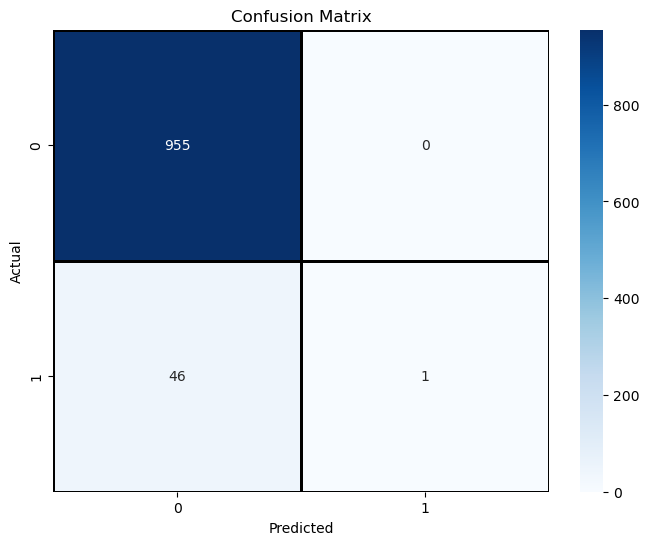

{'Model': LogisticRegression(),
 'Accuracy': 0.9540918163672655,
 'Precision': 1.0,
 'Recall': 0.02127659574468085,
 'Specificity': 1.0,
 'Negative Predictive Value': 0.954045954045954,
 'F1_score': 0.04166666666666667,
 'Mean Cross-Validation': 0.9376094719505854,
 'Confusion matrix': array([[955,   0],
        [ 46,   1]]),
 'Coefficients':                         Feature  Coefficient
 2                      quantity     2.293337
 11                  region_West     1.329977
 44       subcategory_supplies_1     0.591897
 1                         sales     0.339547
 42         subcategory_phones_1    -0.279503
 6      ship_mode_Standard Class    -0.272803
 35        subcategory_copiers_1    -0.264290
 45         subcategory_tables_1    -0.254055
 29    subcategory_accessories_1     0.235487
 17             order_month_June    -0.223852
 15          order_month_January     0.223223
 8           segment_Home Office    -0.207392
 46                hasdiscount_1     0.197112
 33      sub

In [254]:
# Apply logistic regression function
model_lr_original = logistic_regression(X_train_original, X_test_original, y_train_original, y_test_original)
model_lr_original

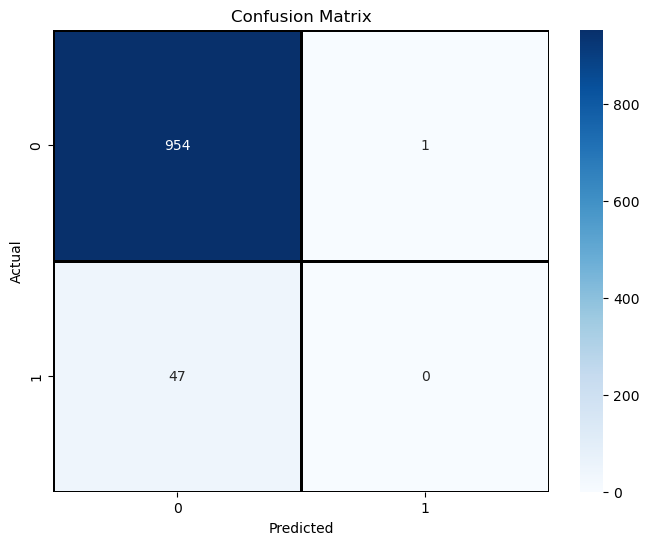

{'Model': RandomForestClassifier(max_features='log2', min_samples_split=6,
                        n_estimators=10),
 'Accuracy': 0.9520958083832335,
 'Precision': 0.0,
 'Recall': 0.0,
 'Specificity': 0.9989528795811519,
 'Negative Predictive Value': 0.9530469530469531,
 'F1_score': 0.0,
 'Mean Cross-Validation': 0.9376091606190515,
 'Confusion matrix': array([[954,   1],
        [ 47,   0]]),
 'Grid search estimators': RandomForestClassifier(max_features='log2', min_samples_split=6,
                        n_estimators=10),
 'Feature importance':                    columns_name  score_feature_importance
 3                        profit                  0.152935
 1                         sales                  0.133662
 2                      quantity                  0.109356
 0                  days_to_ship                  0.060144
 11                  region_West                  0.048216
 24   order_day_of_week_Saturday                  0.018772
 5        ship_mode_Second Class  

In [255]:
# Apply random forest function
model_rf_original = random_forest_classifier(X_train_original, X_test_original, y_train_original, y_test_original)
model_rf_original

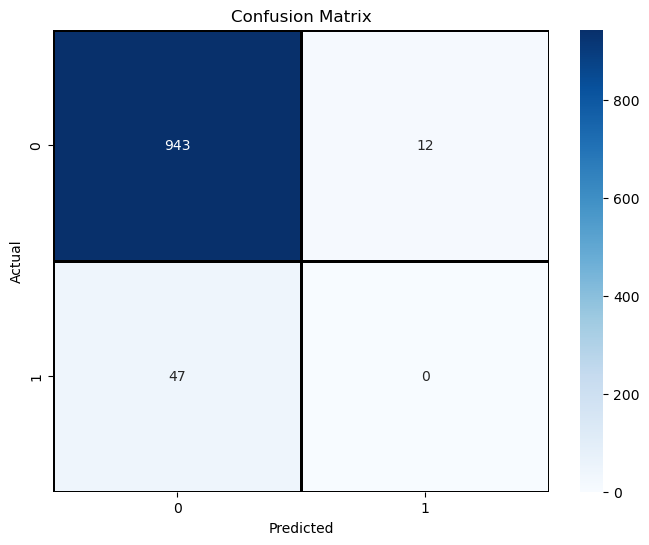

{'Model': KNeighborsClassifier(n_neighbors=3),
 'Accuracy': 0.9411177644710579,
 'Precision': 0.0,
 'Recall': 0.0,
 'Specificity': 0.987434554973822,
 'Negative Predictive Value': 0.9525252525252526,
 'F1_score': 0.0,
 'Mean Cross-Validation': 0.9303728817780765,
 'Confusion matrix': array([[943,  12],
        [ 47,   0]])}

In [256]:
# Apply knn function
model_knn_original = knn_classifier(X_train_original, X_test_original, y_train_original, y_test_original)
model_knn_original

In [257]:
# Model comparison with original data
model_comparison_original = pd.DataFrame({
'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
'Mean Cross Validation':  [model_lr_original['Mean Cross-Validation'], model_rf_original['Mean Cross-Validation'], model_knn_original['Mean Cross-Validation']],
'Accuracy': [model_lr_original['Accuracy'], model_rf_original['Accuracy'], model_knn_original['Accuracy']],
'Precision': [model_lr_original['Precision'], model_rf_original['Precision'], model_knn_original['Precision']],
'Recall': [model_lr_original['Recall'], model_rf_original['Recall'], model_knn_original['Recall']],
'Specificity': [model_lr_original['Specificity'], model_rf_original['Specificity'], model_knn_original['Specificity']],
'Negative Predictive Value': [model_lr_original['Negative Predictive Value'], model_rf_original['Negative Predictive Value'], model_knn_original['Negative Predictive Value']],
'F1score':[model_lr_original['F1_score'], model_rf_original['F1_score'], model_knn_original['F1_score']]
})
model_comparison_original

,Model,Mean Cross Validation,Accuracy,Precision,Recall,Specificity,Negative Predictive Value,F1score
0,Logistic Regression,0.937609,0.954092,1.0,0.021277,1.000000,0.954046,0.041667
1,Random Forest,0.937609,0.952096,0.0,0.000000,0.998953,0.953047,0.000000
2,KNN,0.930373,0.941118,0.0,0.000000,0.987435,0.952525,0.000000


In [258]:
# Different balancing techniques to check model performance: downsample using TomekLinks and upsample using SMOTE

tomek_links= TomekLinks()

X_tl, y_tl = tomek_links.fit_resample(X, y)
y_tl.value_counts()
X_tl_sm, y_tl_sm = smote.fit_resample(X_tl,y_tl)
y_tl_sm.value_counts()

returned
0           4597
1           4597
dtype: int64

In [259]:
# Train test with resampled data
X_train_tl_sm, X_test_tl_sm, y_train_tl_sm, y_test_tl_sm = train_test_split(X_tl_sm, y_tl_sm, test_size=.2, random_state=0)

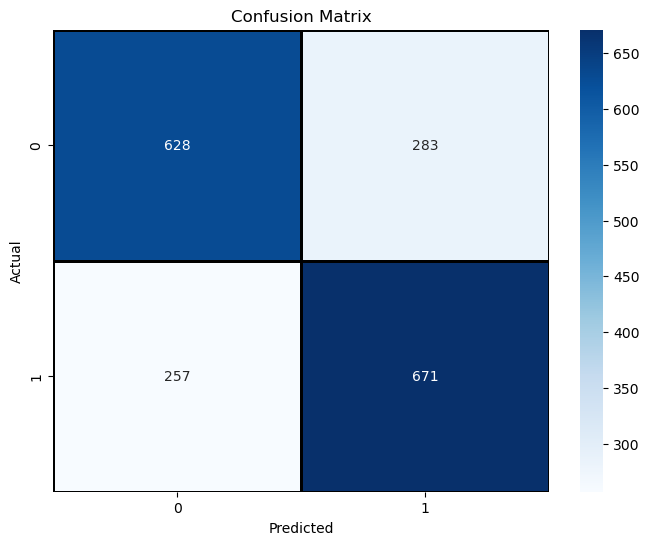

{'Model': LogisticRegression(),
 'Accuracy': 0.7063621533442088,
 'Precision': 0.7033542976939203,
 'Recall': 0.7230603448275862,
 'Specificity': 0.6893523600439078,
 'Negative Predictive Value': 0.7096045197740113,
 'F1_score': 0.7130712008501594,
 'Mean Cross-Validation': 0.7015635622025832,
 'Confusion matrix': array([[628, 283],
        [257, 671]]),
 'Coefficients':                         Feature  Coefficient
 2                      quantity     3.547326
 11                  region_West     1.563072
 17             order_month_June    -1.026644
 45         subcategory_tables_1    -0.978757
 44       subcategory_supplies_1     0.905028
 1                         sales    -0.866990
 19              order_month_May    -0.767665
 12           order_month_August    -0.748593
 22        order_month_September    -0.657644
 28  order_day_of_week_Wednesday    -0.625613
 16             order_month_July    -0.616830
 20         order_month_November    -0.552601
 25     order_day_of_week_Sun

In [260]:
# Call logistic regresion function with resampled data
model_lr_tl_sm = logistic_regression(X_train_tl_sm, X_test_tl_sm, y_train_tl_sm, y_test_tl_sm)
model_lr_tl_sm

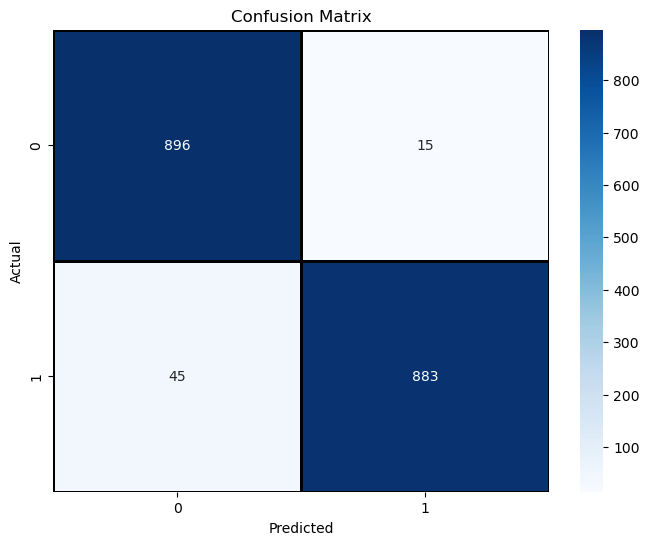

{'Model': RandomForestClassifier(max_features='log2', n_estimators=30),
 'Accuracy': 0.967373572593801,
 'Precision': 0.9832962138084632,
 'Recall': 0.9515086206896551,
 'Specificity': 0.9835345773874863,
 'Negative Predictive Value': 0.9521785334750266,
 'F1_score': 0.9671412924424972,
 'Mean Cross-Validation': 0.9681849082256969,
 'Confusion matrix': array([[896,  15],
        [ 45, 883]]),
 'Grid search estimators': RandomForestClassifier(max_features='log2', n_estimators=30),
 'Feature importance':                    columns_name  score_feature_importance
 11                  region_West                  0.135131
 2                      quantity                  0.106419
 1                         sales                  0.087852
 3                        profit                  0.055255
 0                  days_to_ship                  0.049727
 46                hasdiscount_1                  0.044671
 9                   region_East                  0.037321
 10                 r

In [261]:
# Call knn function with resampled data
model_rf_tl_sm = random_forest_classifier(X_train_tl_sm, X_test_tl_sm, y_train_tl_sm, y_test_tl_sm)
model_rf_tl_sm

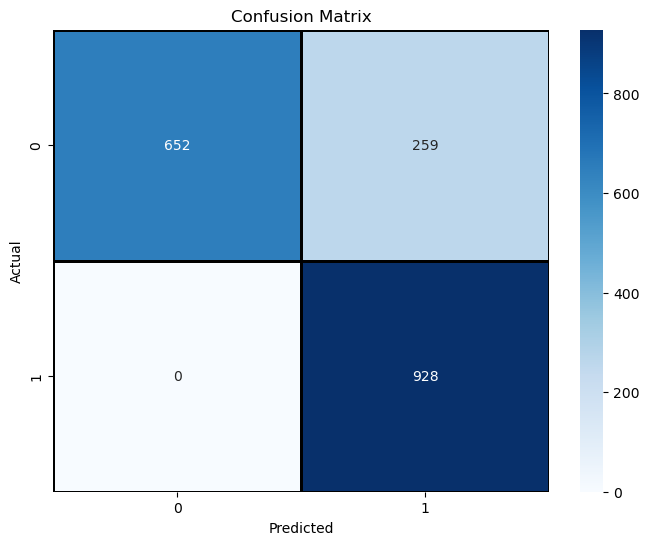

{'Model': KNeighborsClassifier(n_neighbors=3),
 'Accuracy': 0.8591625883632409,
 'Precision': 0.7818028643639428,
 'Recall': 1.0,
 'Specificity': 0.7156970362239298,
 'Negative Predictive Value': 1.0,
 'F1_score': 0.8775413711583925,
 'Mean Cross-Validation': 0.8549286199864039,
 'Confusion matrix': array([[652, 259],
        [  0, 928]])}

In [262]:
# Call knn function with resampled data
model_knn_tl_sm = knn_classifier(X_train_tl_sm, X_test_tl_sm, y_train_tl_sm, y_test_tl_sm)
model_knn_tl_sm

In [263]:
model_comparison_tl_sm = pd.DataFrame({
'Model': ['Logistic Regression', 'Random Forest', 'KNN'],
'Mean Cross Validation':  [model_lr_tl_sm ['Mean Cross-Validation'], model_rf_tl_sm ['Mean Cross-Validation'], model_knn_tl_sm ['Mean Cross-Validation']],
'Accuracy': [model_lr_tl_sm ['Accuracy'], model_rf_tl_sm ['Accuracy'], model_knn_tl_sm ['Accuracy']],
'Precision': [model_lr_tl_sm ['Precision'], model_rf_tl_sm ['Precision'], model_knn_tl_sm ['Precision']],
'Recall': [model_lr_tl_sm ['Recall'], model_rf_tl_sm ['Recall'], model_knn_tl_sm ['Recall']],
'Specificity': [model_lr_tl_sm ['Specificity'], model_rf_tl_sm ['Specificity'], model_knn_tl_sm ['Specificity']],
'Negative Predictive Value': [model_lr_tl_sm ['Negative Predictive Value'], model_rf_tl_sm ['Negative Predictive Value'], model_knn_tl_sm ['Negative Predictive Value']],
'F1score':[model_lr_tl_sm ['F1_score'], model_rf_tl_sm ['F1_score'], model_knn_tl_sm ['F1_score']]
})
model_comparison_tl_sm

,Model,Mean Cross Validation,Accuracy,Precision,Recall,Specificity,Negative Predictive Value,F1score
0,Logistic Regression,0.701564,0.706362,0.703354,0.723060,0.689352,0.709605,0.713071
1,Random Forest,0.968185,0.967374,0.983296,0.951509,0.983535,0.952179,0.967141
2,KNN,0.854929,0.859163,0.781803,1.000000,0.715697,1.000000,0.877541
